In [16]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch

from xgboost import XGBClassifier
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import metrics
from utils import *
from sklearn.model_selection import KFold
from utils import *
import random
from get_sim import *
from sklearn.linear_model import LogisticRegression

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',  # 使用颜色编码定义颜色
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


In [2]:

# random.seed(1)
# k1 = 140  # mic
# k2 = 5  # dis
# A = pd.read_csv('./peryton/sign_final_ass.csv', index_col=0).to_numpy()
# A = pd.read_csv('./peryton/final_ass.csv', index_col=0).to_numpy()

random.seed(2023)
k1 = 30
k2 = 5
A = pd.read_csv('./HMDAD/sign_final_ass.csv', index_col=0).to_numpy()
# A = np.load('./HMDAD/mic-dis Association.npy')

# random.seed(40)
# k1 = 160  # mic
# k2 = 40  # dis
# A = pd.read_csv('./Disbiome/final_ass.csv', index_col=0).to_numpy()
# A = pd.read_csv('./Disbiome/sign_final_ass.csv', index_col=0).to_numpy()

# random.seed(1)
# k1 = 180  # mic
# k2 = 50  # dis
# A = pd.read_csv('./phendb/final_ass.csv', index_col=0).to_numpy()
# A = pd.read_csv('./phendb/sign_final_ass.csv', index_col=0).to_numpy()
print("the number of microbes and diseases", A.shape)
print("the number of associations", sum(sum(A)))

samples = get_all_the_samples_sign(A)
# samples = get_samples_PR_RWR()
# samples = get_samples_PR_RWR_phendb()

the number of microbes and diseases (292, 39)
the number of associations 40.0


In [6]:
# ROC_plot = {}
# ROC_plot = np.load('./sign/latent_comparison/ROC/ROC_plot.npy', allow_pickle=True).item()

############ 0 fold #############
############ 1 fold #############
############ 2 fold #############
############ 3 fold #############
############ 4 fold #############
############ 5 fold #############
############ 6 fold #############
############ 7 fold #############
############ 8 fold #############
############ 9 fold #############


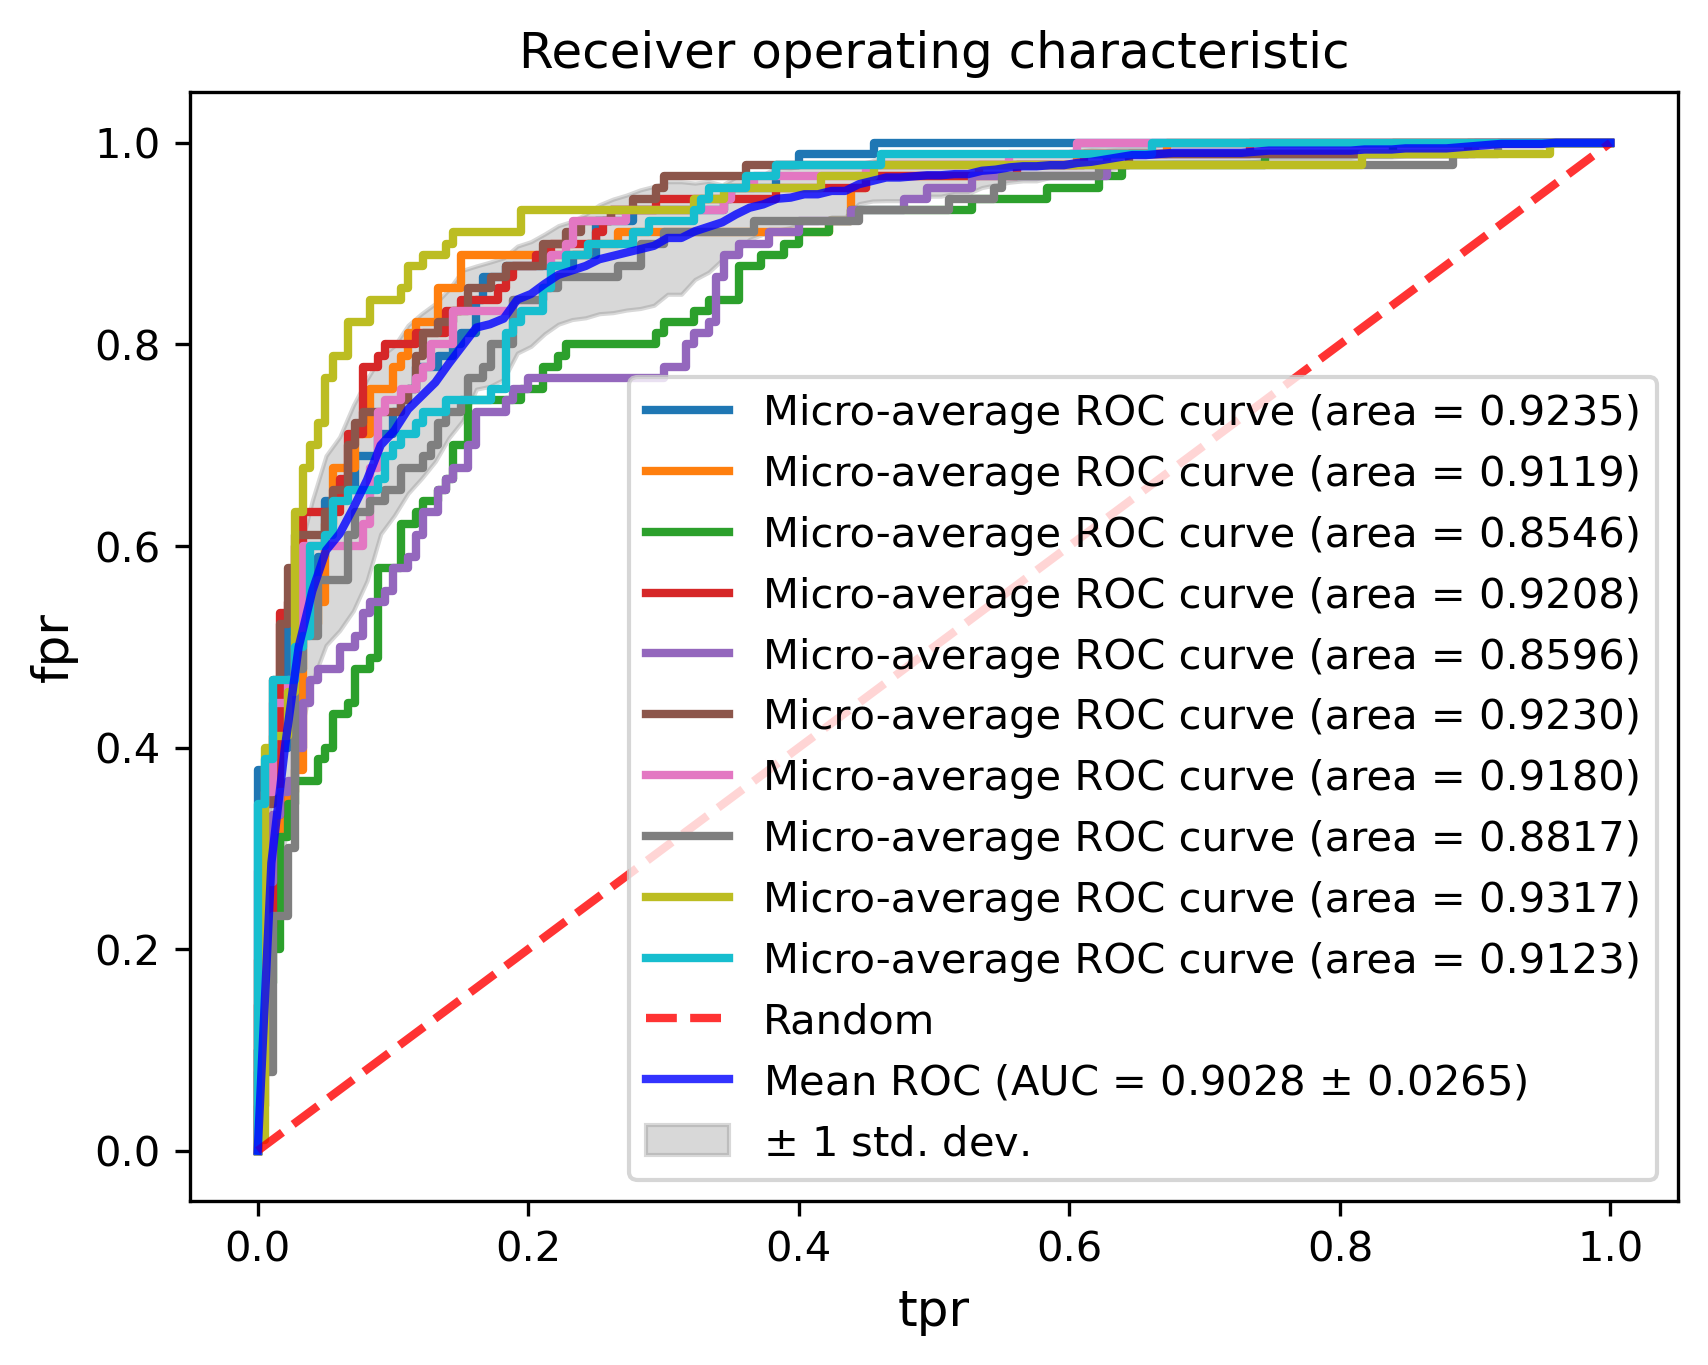

In [3]:
suffix = 'HMDAD_sign2'
latent = np.load('./sign/latent_database/latent_' + suffix + '.npy')
latent_m, latent_d = latent[:A.shape[0],:], latent[A.shape[0]:,:]

# suffix = 'peryton_sign3'
# latent_m = np.load('./sign/latent_comparison/latent_m_' + suffix + '.npy')
# latent_d = np.load('./sign/latent_comparison/latent_d_' + suffix + '.npy')

tprs = []
aucs = []
mean_fpr_ = np.linspace(0, 1, 100)
fig, ax = plt.subplots(dpi=300)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
iter_ = 0  # control each iterator
sum_score = 0
out = []
test_label_score = {}

for j, (train_index, test_index) in enumerate(kf.split(samples)):
    print('############ {} fold #############'.format(j))
    out.append([train_index, test_index])
    iter_ = iter_ + 1
    train_samples = samples[train_index, :]
    test_samples = samples[test_index, :]

    vec_len1 = latent_m.shape[1]
    vec_len2 = latent_d.shape[1]
    train_n = train_samples.shape[0]
    train_feature = np.zeros([train_n, vec_len1 + vec_len2])
    train_label = np.zeros([train_n])

    for i in range(train_n):
        train_feature[i, 0: vec_len1] = latent_m[train_samples[i, 0], :]
        train_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[train_samples[i, 1], :]

        train_label[i] = train_samples[i, 2]

    test_N = test_samples.shape[0]
    test_feature = np.zeros([test_N, vec_len1 + vec_len2])
    test_label = np.zeros(test_N)

    for i in range(test_N):
        test_feature[i, 0: vec_len1] = latent_m[test_samples[i, 0], :]
        test_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[test_samples[i, 1], :]

        test_label[i] = test_samples[i, 2]

    model = xgboost.XGBClassifier(eval_metric=['logloss', 'auc', 'error'], use_label_encoder=True)
    model.fit(train_feature, train_label)

    pre_test_proba = model.predict_proba(test_feature)

    y_test_binary = np.array([1 if i == k else 0 for i in test_label for k in [-1, 0, 1]]).reshape(-1, 3)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_binary[:, i], pre_test_proba[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    fpr["macro"] = all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    temp_mean_tpr = np.zeros_like(all_fpr)
    # 通过trapezoidal规则计算Macro-average ROC曲线和AUC值
    for i in range(3):
        temp_mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    temp_mean_tpr /= 3
    tpr["macro"] = temp_mean_tpr
    roc_auc["macro"] = macro_auc = metrics.auc(all_fpr, temp_mean_tpr)

    # 计算Micro-average ROC曲线和AUC值
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_binary.ravel(), pre_test_proba.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"], color=colors[j], lw=2,
            label='Micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]))
    interp_tpr = np.interp(mean_fpr_, fpr["micro"], tpr["micro"])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc["micro"])

    test_label_score['fold '+str(j)] = [y_test_binary, pre_test_proba]

np.save('./sign/latent_database/'+suffix+'_folds.npy', test_label_score)
folds = test_label_score
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr_, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr_, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr_, tprs_lower, tprs_upper, color='grey', alpha=.3,
                label=r'$\pm$ 1 std. dev.')
ax.set_xlabel('tpr', size=12)
ax.set_ylabel('fpr', size=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
# plt.show()
plt.savefig('./sign/comparison_database/ROC_'+suffix+'.tiff', dpi=300)
# ROC_plot[suffix] = (mean_fpr_, mean_tpr, mean_auc, std_auc)
# np.save('./sign/latent_comparison/ROC/ROC_plot1.npy', ROC_plot)

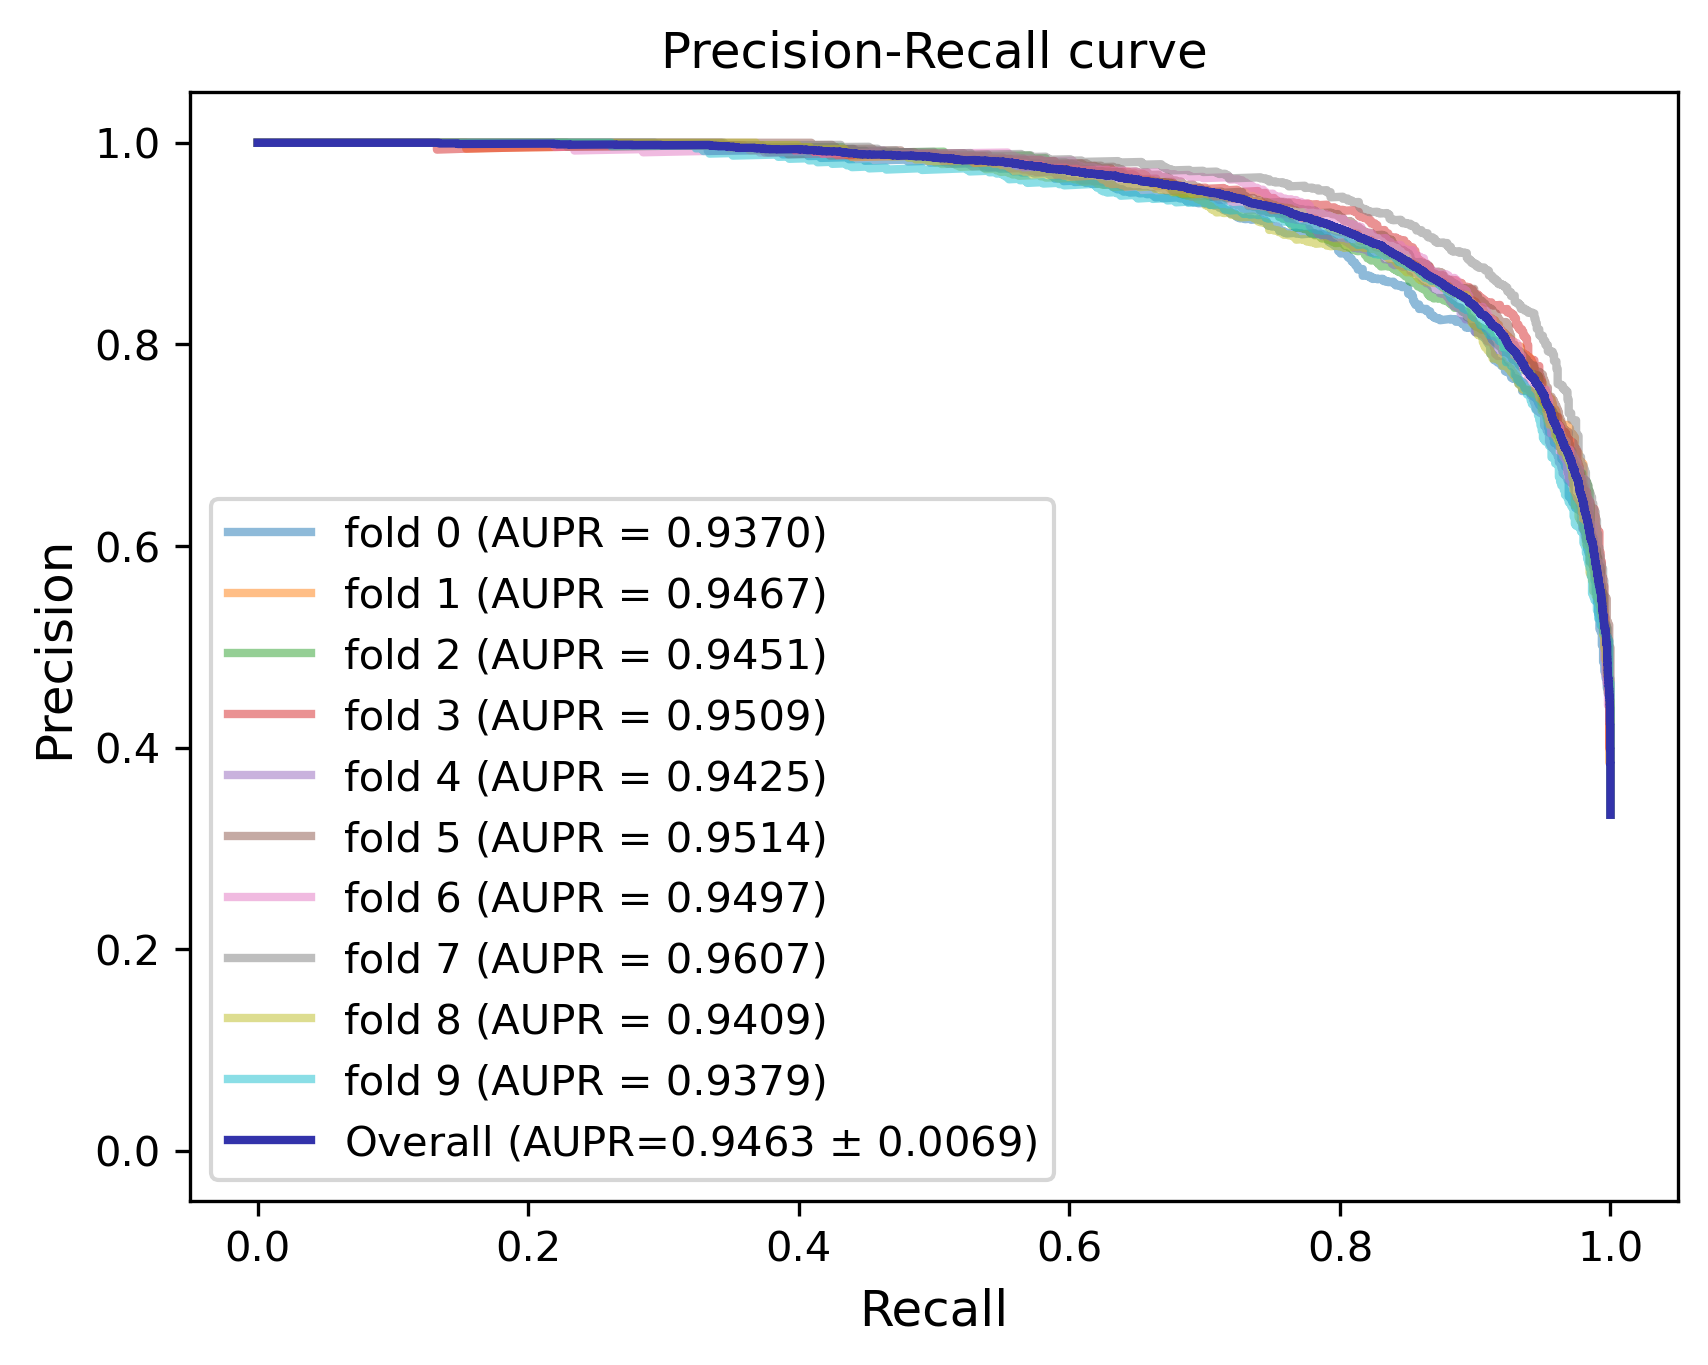

In [19]:
folds = np.load('./sign/latent_database/phendb_sign2_folds.npy', allow_pickle=True).item()
draw_PR_multiclass(folds)
# plt.savefig('./sign/comparison_database/PR_'+suffix+'.tiff', dpi=300)

# disbiome

the number of microbes and diseases (1622, 374)
the number of associations 417.0
############ 0 fold #############
############ 1 fold #############
############ 2 fold #############
############ 3 fold #############
############ 4 fold #############
############ 5 fold #############
############ 6 fold #############
############ 7 fold #############
############ 8 fold #############
############ 9 fold #############


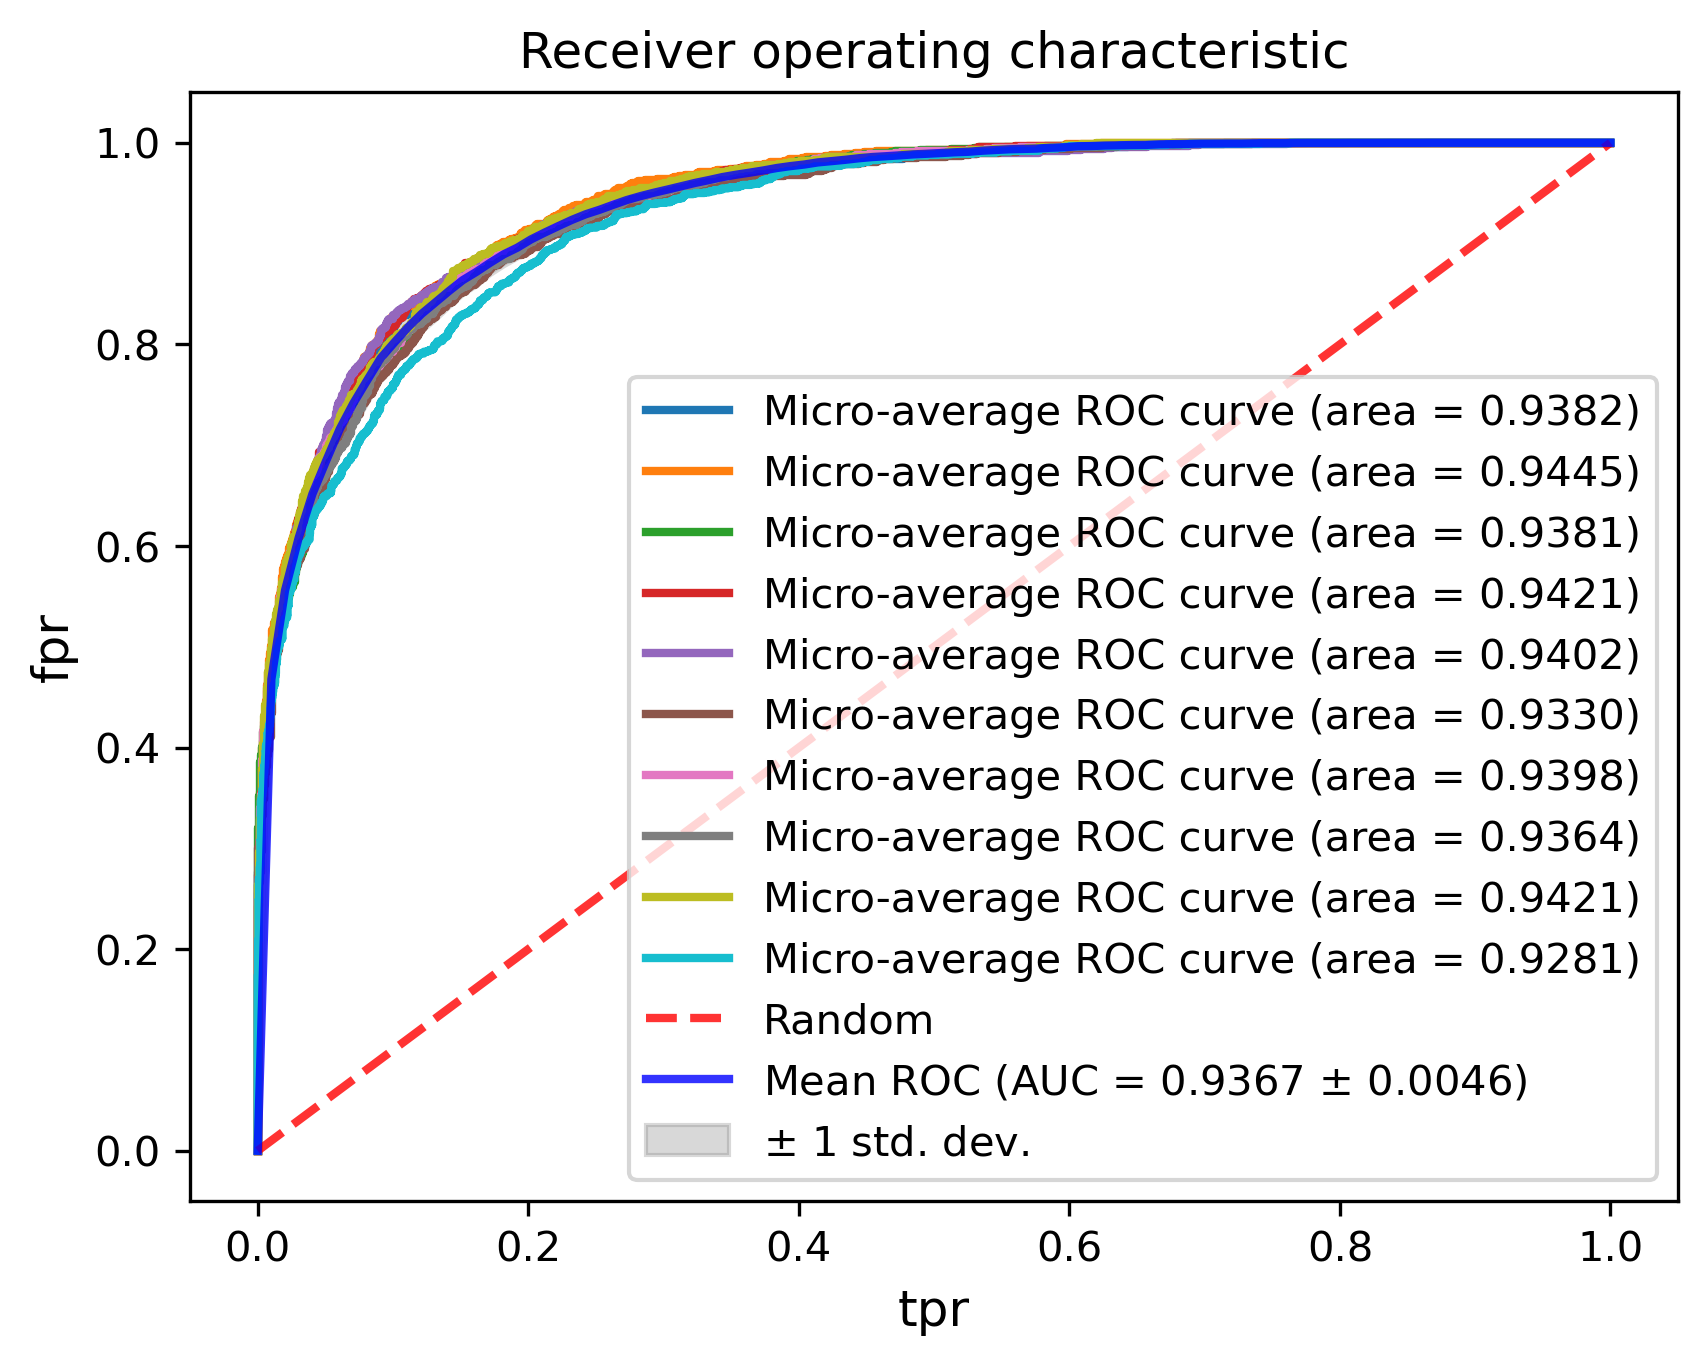

In [4]:
random.seed(40)
k1 = 160  # mic
k2 = 40  # dis
# A = pd.read_csv('./Disbiome/final_ass.csv', index_col=0).to_numpy()
A = pd.read_csv('./Disbiome/sign_final_ass.csv', index_col=0).to_numpy()
print("the number of microbes and diseases", A.shape)
print("the number of associations", sum(sum(A)))

samples = get_all_the_samples_sign(A)

suffix = 'biome_sign2'
latent = np.load('./sign/latent_database/latent_' + suffix + '.npy')
latent_m, latent_d = latent[:A.shape[0],:], latent[A.shape[0]:,:]

tprs = []
aucs = []
mean_fpr_ = np.linspace(0, 1, 100)
fig, ax = plt.subplots(dpi=300)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
iter_ = 0  # control each iterator
sum_score = 0
out = []
test_label_score = {}

for j, (train_index, test_index) in enumerate(kf.split(samples)):
    print('############ {} fold #############'.format(j))
    out.append([train_index, test_index])
    iter_ = iter_ + 1
    train_samples = samples[train_index, :]
    test_samples = samples[test_index, :]

    vec_len1 = latent_m.shape[1]
    vec_len2 = latent_d.shape[1]
    train_n = train_samples.shape[0]
    train_feature = np.zeros([train_n, vec_len1 + vec_len2])
    train_label = np.zeros([train_n])

    for i in range(train_n):
        train_feature[i, 0: vec_len1] = latent_m[train_samples[i, 0], :]
        train_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[train_samples[i, 1], :]

        train_label[i] = train_samples[i, 2]

    test_N = test_samples.shape[0]
    test_feature = np.zeros([test_N, vec_len1 + vec_len2])
    test_label = np.zeros(test_N)

    for i in range(test_N):
        test_feature[i, 0: vec_len1] = latent_m[test_samples[i, 0], :]
        test_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[test_samples[i, 1], :]

        test_label[i] = test_samples[i, 2]

    model = xgboost.XGBClassifier(eval_metric=['logloss', 'auc', 'error'], use_label_encoder=True)
    model.fit(train_feature, train_label)

    pre_test_proba = model.predict_proba(test_feature)

    y_test_binary = np.array([1 if i == k else 0 for i in test_label for k in [-1, 0, 1]]).reshape(-1, 3)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_binary[:, i], pre_test_proba[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    fpr["macro"] = all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    temp_mean_tpr = np.zeros_like(all_fpr)
    # 通过trapezoidal规则计算Macro-average ROC曲线和AUC值
    for i in range(3):
        temp_mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    temp_mean_tpr /= 3
    tpr["macro"] = temp_mean_tpr
    roc_auc["macro"] = macro_auc = metrics.auc(all_fpr, temp_mean_tpr)

    # 计算Micro-average ROC曲线和AUC值
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_binary.ravel(), pre_test_proba.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"], color=colors[j], lw=2,
            label='Micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]))
    interp_tpr = np.interp(mean_fpr_, fpr["micro"], tpr["micro"])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc["micro"])

    test_label_score['fold '+str(j)] = [y_test_binary, pre_test_proba]

np.save('./sign/latent_database/'+suffix+'_folds.npy', test_label_score)
folds = test_label_score
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr_, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr_, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr_, tprs_lower, tprs_upper, color='grey', alpha=.3,
                label=r'$\pm$ 1 std. dev.')
ax.set_xlabel('tpr', size=12)
ax.set_ylabel('fpr', size=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
# plt.show()
plt.savefig('./sign/comparison_database/ROC_'+suffix+'.tiff', dpi=300)
# ROC_plot[suffix] = (mean_fpr_, mean_tpr, mean_auc, std_auc)
# np.save('./sign/latent_comparison/ROC/ROC_plot1.npy', ROC_plot)

# phendb

In [5]:
random.seed(1)
k1 = 180  # mic
k2 = 50  # dis
A = pd.read_csv('./phendb/sign_final_ass.csv', index_col=0).to_numpy()

print("the number of microbes and diseases", A.shape)
print("the number of associations", sum(sum(A)))

samples = get_all_the_samples_sign(A)

the number of microbes and diseases (1774, 500)
the number of associations 1873.0


############ 0 fold #############
############ 1 fold #############
############ 2 fold #############
############ 3 fold #############
############ 4 fold #############
############ 5 fold #############
############ 6 fold #############
############ 7 fold #############
############ 8 fold #############
############ 9 fold #############


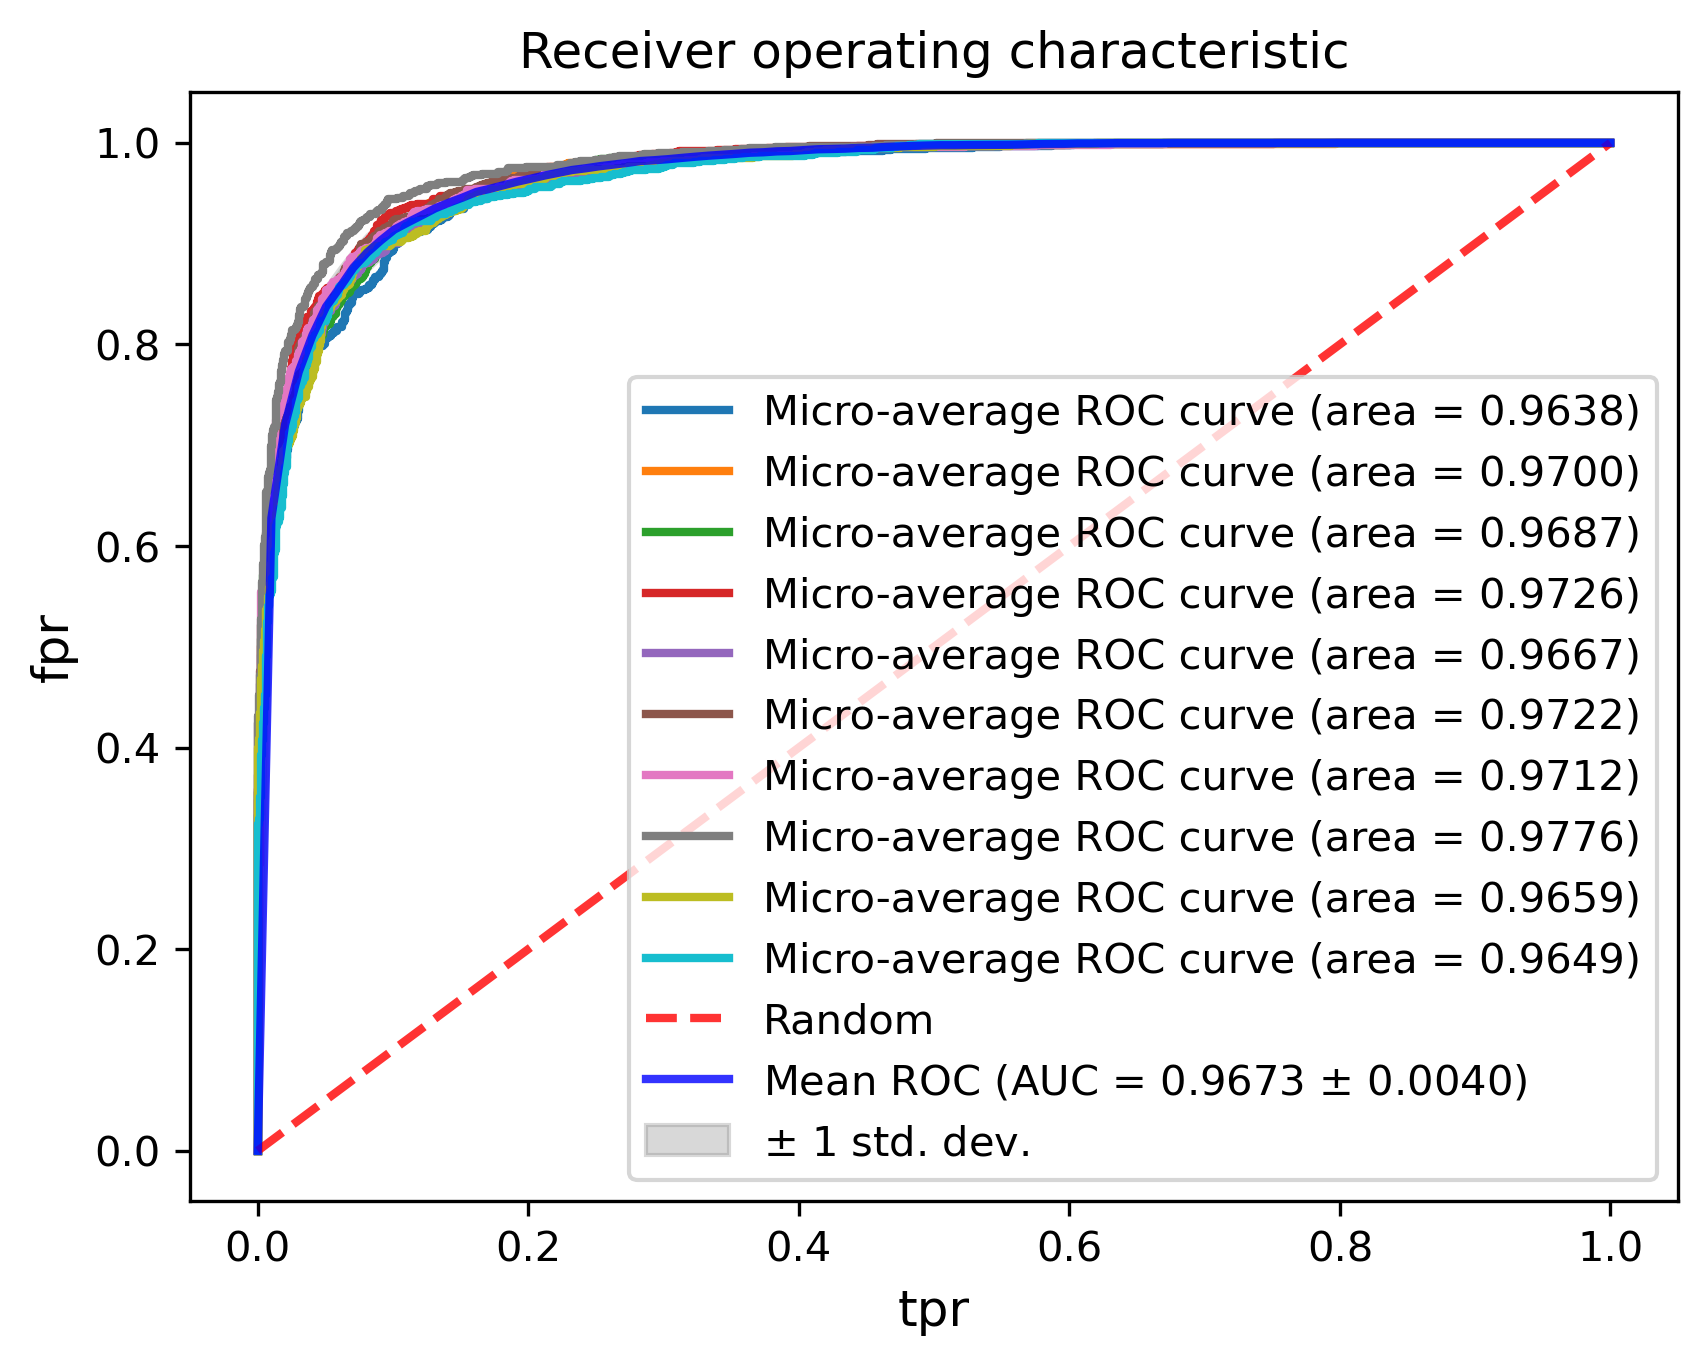

In [6]:
suffix = 'phendb_sign2'
latent = np.load('./sign/latent_database/latent_' + suffix + '.npy')
latent_m, latent_d = latent[:A.shape[0],:], latent[A.shape[0]:,:]

tprs = []
aucs = []
mean_fpr_ = np.linspace(0, 1, 100)
fig, ax = plt.subplots(dpi=300)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
iter_ = 0  # control each iterator
sum_score = 0
out = []
test_label_score = {}

for j, (train_index, test_index) in enumerate(kf.split(samples)):
    print('############ {} fold #############'.format(j))
    out.append([train_index, test_index])
    iter_ = iter_ + 1
    train_samples = samples[train_index, :]
    test_samples = samples[test_index, :]

    vec_len1 = latent_m.shape[1]
    vec_len2 = latent_d.shape[1]
    train_n = train_samples.shape[0]
    train_feature = np.zeros([train_n, vec_len1 + vec_len2])
    train_label = np.zeros([train_n])

    for i in range(train_n):
        train_feature[i, 0: vec_len1] = latent_m[train_samples[i, 0], :]
        train_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[train_samples[i, 1], :]

        train_label[i] = train_samples[i, 2]

    test_N = test_samples.shape[0]
    test_feature = np.zeros([test_N, vec_len1 + vec_len2])
    test_label = np.zeros(test_N)

    for i in range(test_N):
        test_feature[i, 0: vec_len1] = latent_m[test_samples[i, 0], :]
        test_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[test_samples[i, 1], :]

        test_label[i] = test_samples[i, 2]

    model = xgboost.XGBClassifier(eval_metric=['logloss', 'auc', 'error'], use_label_encoder=True)
    model.fit(train_feature, train_label)

    pre_test_proba = model.predict_proba(test_feature)

    y_test_binary = np.array([1 if i == k else 0 for i in test_label for k in [-1, 0, 1]]).reshape(-1, 3)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_binary[:, i], pre_test_proba[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    fpr["macro"] = all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    temp_mean_tpr = np.zeros_like(all_fpr)
    # 通过trapezoidal规则计算Macro-average ROC曲线和AUC值
    for i in range(3):
        temp_mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    temp_mean_tpr /= 3
    tpr["macro"] = temp_mean_tpr
    roc_auc["macro"] = macro_auc = metrics.auc(all_fpr, temp_mean_tpr)

    # 计算Micro-average ROC曲线和AUC值
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_binary.ravel(), pre_test_proba.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"], color=colors[j], lw=2,
            label='Micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]))
    interp_tpr = np.interp(mean_fpr_, fpr["micro"], tpr["micro"])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc["micro"])

    test_label_score['fold '+str(j)] = [y_test_binary, pre_test_proba]

np.save('./sign/latent_database/'+suffix+'_folds.npy', test_label_score)
folds = test_label_score
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr_, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr_, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr_, tprs_lower, tprs_upper, color='grey', alpha=.3,
                label=r'$\pm$ 1 std. dev.')
ax.set_xlabel('tpr', size=12)
ax.set_ylabel('fpr', size=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
# plt.show()
plt.savefig('./sign/comparison_database/ROC_'+suffix+'.tiff', dpi=300)
# ROC_plot[suffix] = (mean_fpr_, mean_tpr, mean_auc, std_auc)
# np.save('./sign/latent_comparison/ROC/ROC_plot1.npy', ROC_plot)

# test disbiome random seed

In [18]:
from tqdm import tqdm

In [19]:
outcome = []
seeds = range(2) 
for item in tqdm(seeds):   
    random.seed(item)
    A = pd.read_csv('./Disbiome/sign_final_ass.csv', index_col=0).to_numpy()

    samples = get_all_the_samples_sign(A)

    suffix = 'biome_sign2'
    latent = np.load('./sign/latent_database/latent_' + suffix + '.npy')
    latent_m, latent_d = latent[:A.shape[0],:], latent[A.shape[0]:,:]

    tprs = []
    aucs = []
    mean_fpr_ = np.linspace(0, 1, 100)
    # fig, ax = plt.subplots(dpi=300)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    iter_ = 0  # control each iterator
    sum_score = 0
    out = []
    test_label_score = {}

    for j, (train_index, test_index) in enumerate(kf.split(samples)):
        # print('############ {} fold #############'.format(j))
        out.append([train_index, test_index])
        iter_ = iter_ + 1
        train_samples = samples[train_index, :]
        test_samples = samples[test_index, :]

        vec_len1 = latent_m.shape[1]
        vec_len2 = latent_d.shape[1]
        train_n = train_samples.shape[0]
        train_feature = np.zeros([train_n, vec_len1 + vec_len2])
        train_label = np.zeros([train_n])

        for i in range(train_n):
            train_feature[i, 0: vec_len1] = latent_m[train_samples[i, 0], :]
            train_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[train_samples[i, 1], :]

            train_label[i] = train_samples[i, 2]

        test_N = test_samples.shape[0]
        test_feature = np.zeros([test_N, vec_len1 + vec_len2])
        test_label = np.zeros(test_N)

        for i in range(test_N):
            test_feature[i, 0: vec_len1] = latent_m[test_samples[i, 0], :]
            test_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[test_samples[i, 1], :]

            test_label[i] = test_samples[i, 2]

        model = xgboost.XGBClassifier(eval_metric=['logloss', 'auc', 'error'], use_label_encoder=True)
        model.fit(train_feature, train_label)

        pre_test_proba = model.predict_proba(test_feature)

        y_test_binary = np.array([1 if i == k else 0 for i in test_label for k in [-1, 0, 1]]).reshape(-1, 3)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test_binary[:, i], pre_test_proba[:, i])
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])

        fpr["macro"] = all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
        temp_mean_tpr = np.zeros_like(all_fpr)
        # 通过trapezoidal规则计算Macro-average ROC曲线和AUC值
        for i in range(3):
            temp_mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        temp_mean_tpr /= 3
        tpr["macro"] = temp_mean_tpr
        roc_auc["macro"] = macro_auc = metrics.auc(all_fpr, temp_mean_tpr)

        # 计算Micro-average ROC曲线和AUC值
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_binary.ravel(), pre_test_proba.ravel())
        roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

        # ax.plot(fpr["micro"], tpr["micro"], color=colors[j], lw=2,
        #         label='Micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]))
        interp_tpr = np.interp(mean_fpr_, fpr["micro"], tpr["micro"])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc["micro"])

        test_label_score['fold '+str(j)] = [y_test_binary, pre_test_proba]

    # np.save('./sign/latent_database/'+suffix+'_folds.npy', test_label_score)
    folds = test_label_score
    # ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    #         label='Random', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr_, mean_tpr)
    std_auc = np.std(aucs)
    # ax.plot(mean_fpr_, mean_tpr, color='b',
    #         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
    #         lw=2, alpha=.8)
    outcome.append(mean_auc)


100%|██████████| 2/2 [03:44<00:00, 112.20s/it]


In [21]:
np.save('./sign/latent_database/test_seed/biome.npy', np.array(outcome))

# test hmdad random seed 

In [22]:
outcome = []
seeds = range(2) 
for item in tqdm(seeds):   
    random.seed(item)
    A = pd.read_csv('./HMDAD/sign_final_ass.csv', index_col=0).to_numpy()
    samples = get_all_the_samples_sign(A)

    suffix = 'HMDAD_sign2'
    latent = np.load('./sign/latent_database/latent_' + suffix + '.npy')
    latent_m, latent_d = latent[:A.shape[0],:], latent[A.shape[0]:,:]

    tprs = []
    aucs = []
    mean_fpr_ = np.linspace(0, 1, 100)
    # fig, ax = plt.subplots(dpi=300)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    iter_ = 0  # control each iterator
    sum_score = 0
    out = []
    test_label_score = {}

    for j, (train_index, test_index) in enumerate(kf.split(samples)):
        # print('############ {} fold #############'.format(j))
        out.append([train_index, test_index])
        iter_ = iter_ + 1
        train_samples = samples[train_index, :]
        test_samples = samples[test_index, :]

        vec_len1 = latent_m.shape[1]
        vec_len2 = latent_d.shape[1]
        train_n = train_samples.shape[0]
        train_feature = np.zeros([train_n, vec_len1 + vec_len2])
        train_label = np.zeros([train_n])

        for i in range(train_n):
            train_feature[i, 0: vec_len1] = latent_m[train_samples[i, 0], :]
            train_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[train_samples[i, 1], :]

            train_label[i] = train_samples[i, 2]

        test_N = test_samples.shape[0]
        test_feature = np.zeros([test_N, vec_len1 + vec_len2])
        test_label = np.zeros(test_N)

        for i in range(test_N):
            test_feature[i, 0: vec_len1] = latent_m[test_samples[i, 0], :]
            test_feature[i, vec_len1: (vec_len1 + vec_len2)] = latent_d[test_samples[i, 1], :]

            test_label[i] = test_samples[i, 2]

        model = xgboost.XGBClassifier(eval_metric=['logloss', 'auc', 'error'], use_label_encoder=True)
        model.fit(train_feature, train_label)

        pre_test_proba = model.predict_proba(test_feature)

        y_test_binary = np.array([1 if i == k else 0 for i in test_label for k in [-1, 0, 1]]).reshape(-1, 3)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test_binary[:, i], pre_test_proba[:, i])
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])

        fpr["macro"] = all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
        temp_mean_tpr = np.zeros_like(all_fpr)
        # 通过trapezoidal规则计算Macro-average ROC曲线和AUC值
        for i in range(3):
            temp_mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        temp_mean_tpr /= 3
        tpr["macro"] = temp_mean_tpr
        roc_auc["macro"] = macro_auc = metrics.auc(all_fpr, temp_mean_tpr)

        # 计算Micro-average ROC曲线和AUC值
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_binary.ravel(), pre_test_proba.ravel())
        roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

        # ax.plot(fpr["micro"], tpr["micro"], color=colors[j], lw=2,
        #         label='Micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]))
        interp_tpr = np.interp(mean_fpr_, fpr["micro"], tpr["micro"])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc["micro"])

        test_label_score['fold '+str(j)] = [y_test_binary, pre_test_proba]

    # np.save('./sign/latent_database/'+suffix+'_folds.npy', test_label_score)
    folds = test_label_score
    # ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    #         label='Random', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr_, mean_tpr)
    std_auc = np.std(aucs)
    # ax.plot(mean_fpr_, mean_tpr, color='b',
    #         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
    #         lw=2, alpha=.8)
    outcome.append(mean_auc)
np.save('./sign/latent_database/test_seed/hmdad.npy', np.array(outcome))

100%|██████████| 2/2 [02:01<00:00, 60.75s/it]


In [8]:
ttt = test_label_score['fold 0']
